# Neural Style Transfer
This notebook was modified and adapted from a programming exercise from Coursera and DeepLearning.AI's Convolutional Neural Networks course. The original algorithm is attributed to [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576).

The purpose of this notebook is to allow the user to streamline the creation of their own artistic images, using the idea of neural style transfer.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from nst_utils1 import *
import numpy as np
import tensorflow as tf

import imageio

%matplotlib inline

# Load your Images
These steps can be skipped, but I find it's nice to see your images before they are combined and changed.

You will want to put the `content_image` and `style_image` in your `images` folder. My content image is a picture of my backyard, and my style image is Claude Monet's Water Lillies.

### **IMPORTANT:** Both the content and style images must be scaled to 400 x 300 pixels. This requirement can be changed in the CONFIG class in the nst_utils1 file.
Changing the image sizes requires a kernel restart. In my experience, bumping up to 800 x 600 significant increases the computational time.

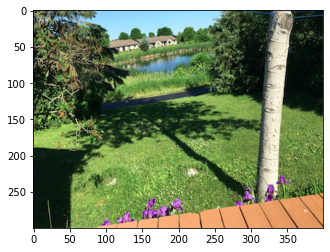

In [2]:
content_image=imageio.imread("images/backyard.png")

# See the input content_image
imshow(content_image)

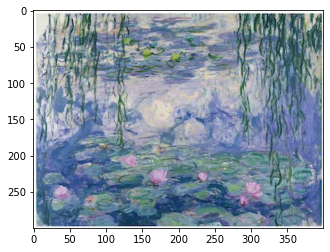

In [3]:
# Load and see your style image.
style_image = imageio.imread("images/water_lillies.jpg")
imshow(style_image)

We need the following functions.

In [4]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content 
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, [m, n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [m, n_H*n_W, n_C])
    
    # compute the cost with tensorflow
    J_content = 1/(4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.reshape(tf.transpose(a_S, [0,3,1,2]),[ n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G, [0,3,1,2]),[ n_C, n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = 1/((2 * n_C * n_H * n_W)**2) * tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    return J_style_layer

# These weights should sum to 1. They give weight to the level of detail in the images.
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style




# Initialize TensorFlow Session and Produce Images

In [5]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

## Load the images and Pre-trained Model
It is frequently very expensive and time-consuming to train convolutional neural nets. Fortunately, we can use pre-trained models and avoid training them ourselves. The idea of using a pre-trained model for a different task is called *transfer learning*.

### You need to download a large file here.
We will need the VGG-network which can be downloaded from [Kaggle](https://www.kaggle.com/teksab/imagenetvggverydeep19mat). You will need to download the file (~500MB) [here](https://www.kaggle.com/teksab/imagenetvggverydeep19mat), and place the file in the folder (directory) with this Jupyter notebook. The file name should be `imagenet-vgg-verydeep-19.mat`.

In [6]:
# Put your own images in the images folder. Change pathname here.
content_image=imageio.imread("images/backyard.png")
content_image = reshape_and_normalize_image(content_image[:,:,:3])

# Put your own images in the images folder. Change pathname here.
style_image = imageio.imread("images/water_lillies.jpg")
style_image = reshape_and_normalize_image(style_image[:,:,:3])

# Perturbs input image to initalize style transfer process.
generated_image = generate_noise_image(content_image)

# Loads model. The file below needs to be downloaded ahead of time and placed in the same directory
# as this notebook.
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [7]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [8]:
# Define total cost (J). 
# The parameters alpha and beta are weights given to the content image or style image.
# These parameters can be manipulated if desired.
alpha=5
beta=100
J = alpha*J_content +  beta*J_style

In [9]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model["input"])

        # Print every 20 iteration. Modify this to your liking.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [10]:
# Change the number of iterations. You can start with 200 to see some changes.
# You may want to go as high as 2000 to see more dramatic effects. Note this will take longer.
model_nn(sess, generated_image, num_iterations=200)
sess.close()

Iteration 0 :
total cost = 8496305700.0
content cost = 8664.832
style cost = 84962620.0
Iteration 20 :
total cost = 1166000600.0
content cost = 13022.6455
style cost = 11659355.0
Iteration 40 :
total cost = 401316320.0
content cost = 15175.63
style cost = 4012404.5
Iteration 60 :
total cost = 223586960.0
content cost = 16211.348
style cost = 2235059.0
Iteration 80 :
total cost = 152147780.0
content cost = 16851.602
style cost = 1520635.2
Iteration 100 :
total cost = 114714616.0
content cost = 17322.688
style cost = 1146280.0
Iteration 120 :
total cost = 91867896.0
content cost = 17707.654
style cost = 917793.6
Iteration 140 :
total cost = 76413736.0
content cost = 18028.969
style cost = 763235.94
Iteration 160 :
total cost = 65144610.0
content cost = 18299.533
style cost = 650531.1
Iteration 180 :
total cost = 56631950.0
content cost = 18534.846
style cost = 565392.75
Iteration 200 :
total cost = 49957864.0
content cost = 18732.547
style cost = 498642.0
Iteration 220 :
total cost = 445

In [11]:
# Close the TensorFlow session
sess.close()